Finding effective adversarial bias field for data augmentation

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import math
import torch

from utils import get_unet_model
from adv_bias import AdvBias
from utils import _disable_tracking_bn_stats,set_grad
from adv_compose_solver import ComposeAdversarialTransformSolver
from loss import cross_entropy_2D

1. 1 Load data

In [24]:
image_path ='./data/img.nrrd'
label_path ='./data/seg.nrrd'

image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))

print ('image size:',image.shape)
print ('label size:',label.shape)



image size: (10, 271, 228)
label size: (10, 271, 228)


1.2 Preprocessing data

In [25]:
## central crop them to [128,128]
crop_size =(128,128)
h_diff = (image.shape[1]-crop_size[0])//2
w_diff = (image.shape[2]-crop_size[1])//2

cropped_images = image[:,h_diff:crop_size[0]+h_diff,w_diff:crop_size[1]+w_diff]
cropped_labels = label[:,h_diff:crop_size[0]+h_diff,w_diff:crop_size[1]+w_diff]

cropped_labels[cropped_labels==1]=0
cropped_labels[cropped_labels==3]=0

# rescale image intensities to 0-1
cropped_images = (cropped_images-cropped_images.min())/(cropped_images.max()-cropped_images.min()+1e-10)
cropped_images.shape




(10, 128, 128)

(-0.5, 127.5, 127.5, -0.5)

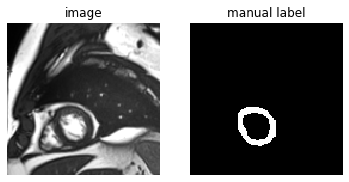

In [26]:
slice_id=7
font_size=12
plt.subplot(121)
plt.title('image',size=font_size)
plt.imshow(cropped_images[slice_id],cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(cropped_labels[slice_id],cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')


2.1 Load a segmentation model

In [27]:
use_gpu=True
model = get_unet_model(num_classes=2,model_path='./saved_checkpoints/myo_seg_unet_16.pth',model_arch='UNet_16')
if use_gpu: 
    model = model.cuda()
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

(-0.5, 127.5, 127.5, -0.5)

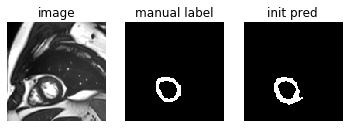

In [28]:
image_tensor = torch.from_numpy(cropped_images[:,np.newaxis,:,:]).float()
target_tensor = torch.from_numpy(cropped_labels).long()

if use_gpu: 
    image_tensor = image_tensor.cuda()
    target_tensor = target_tensor.cuda()
image_tensor.requires_grad=False
target_tensor.requires_grad=False

with torch.no_grad():
    init_output = model(image_tensor)
pred_map = init_output.max(1)[1].cpu().data.numpy()

plt.subplot(131)
plt.title('image',size=font_size)
plt.imshow(cropped_images[slice_id],cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(cropped_labels[slice_id],cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')
plt.subplot(133)
plt.imshow(pred_map[slice_id],cmap='gray')
plt.title('init pred',size=font_size)
plt.axis('off')

2.2 Set up  bias field configurations

In [29]:
augmentor_bias= AdvBias(
                 config_dict={'epsilon':0.3,
                 'control_point_spacing':[crop_size[0]//4,crop_size[1]//4],
                 'downscale':2,
                 'data_size':[image_tensor.size(0),image_tensor.size(1),image_tensor.size(2),image_tensor.size(3)],
                 'interpolation_order':3,
                 'init_mode':'random',
                 'space':'log'},debug=False)


3 Perform random bias field augmentation

(-0.5, 127.5, 127.5, -0.5)

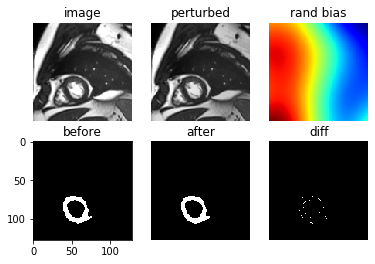

In [30]:
augmentor_bias.init_parameters()
rand_biased_image_tensor = augmentor_bias.forward(image_tensor) 
rand_pred_map = model(rand_biased_image_tensor.detach().clone()).max(1)[1].cpu().data.numpy()
perturbed_image =rand_biased_image_tensor.cpu().numpy()
rand_bias= augmentor_bias.bias_field.cpu().numpy()

plt.subplot(231)
plt.title('image',size=font_size)
plt.axis('off')
plt.imshow(cropped_images[slice_id],cmap='gray')
plt.subplot(232)
plt.title('perturbed',size=font_size)
plt.axis('off')
plt.imshow(perturbed_image[slice_id,0],cmap='gray')
plt.subplot(233)
plt.title('rand bias',size=font_size)
plt.axis('off')
plt.imshow(rand_bias[slice_id,0],cmap='jet')
plt.subplot(234)
plt.imshow(pred_map[slice_id],cmap='gray')
plt.title('before',size=font_size)
plt.subplot(235)
plt.imshow(rand_pred_map[slice_id],cmap='gray')
plt.title('after',size=font_size)
plt.axis('off')
plt.subplot(236)
plt.imshow(abs(rand_pred_map[slice_id]-pred_map[slice_id]),cmap='gray')
plt.title('diff',size=font_size)
plt.axis('off')


4.1 Set up learner to optimize bias field 

In [31]:
solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=[augmentor_bias],
        divergence_types = ['kl','contour'], ### you can also change it to 'mse' for mean squared error loss
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True,
       )

## 4. start learning
solver.init_random_transformation()
rand_transformed_image = solver.forward(image_tensor.detach().clone())

4.2 Apply adversarial data augmentation for network training

In [32]:
## apply adversarial training to find effective bias field
solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=[augmentor_bias],
        divergence_types = ['kl','contour'], ### you can also change it to 'mse' for mean squared error loss
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True,
       )

## 4. start learning
solver.init_random_transformation()
rand_transformed_image = solver.forward(image_tensor.detach().clone())
rand_predict = model.forward(rand_transformed_image)
rand_bias = augmentor_bias.bias_field

model.zero_grad()
## 4.2 adv data augmentation 
loss = solver.adversarial_training(
        data=image_tensor,model=model,
        n_iter=1,
        lazy_load=[True], ## if set to true, it will use the previous sampled random bias field as initialization.
        optimize_flags=[True],power_iteration=False)

adv_bias= augmentor_bias.bias_field

adv_transformed_image = solver.forward(image_tensor.detach().clone())
adv_predict = model.forward(adv_transformed_image)

[True]
kl:0.005854813847690821
contour:0.006964904256165028
0 inner loop: dist 0.009337265975773335
update bias parameters
kl:0.12441892921924591
contour:0.14556251466274261
outer loop loss 0.19720017910003662
init out torch.Size([10, 2, 128, 128])


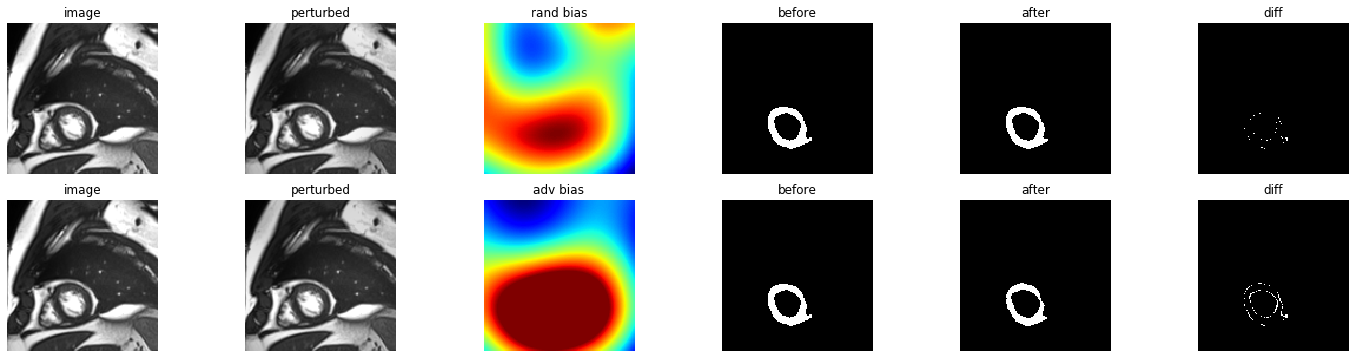

In [33]:
rand_transformed_image_numpy=rand_transformed_image.cpu().data.numpy()[slice_id,0]
adv_transformed_image_numpy=adv_transformed_image.cpu().data.numpy()[slice_id,0]

rand_predict_numpy=rand_predict.max(1)[1].cpu().data.numpy()[slice_id]
adv_predict_numpy=adv_predict.max(1)[1].cpu().data.numpy()[slice_id]

rand_bias_numpy=rand_bias.cpu().data.numpy()[slice_id,0]
adv_bias_numpy=adv_bias.cpu().data.numpy()[slice_id,0]

plt.figure(figsize=(20,10))
plt.subplot(461)
plt.title('image',size=font_size)
plt.axis('off')
plt.imshow(cropped_images[slice_id],cmap='gray')
plt.subplot(462)
plt.title('perturbed',size=font_size)
plt.axis('off')
plt.imshow(rand_transformed_image_numpy,cmap='gray')
plt.subplot(463)
plt.imshow(rand_bias_numpy,cmap='jet')
plt.title('rand bias',size=font_size)
plt.axis('off')

plt.subplot(464)
plt.title('before',size=font_size)
plt.axis('off')
plt.imshow(pred_map[slice_id],cmap='gray')
plt.subplot(465)
plt.title('after',size=font_size)
plt.axis('off')
plt.imshow(rand_predict_numpy,cmap='gray')
plt.subplot(466)
plt.imshow(abs(rand_predict_numpy-pred_map[slice_id]),cmap='gray')
plt.title('diff',size=font_size)
plt.axis('off')


plt.subplot(467)
plt.title('image',size=font_size)
plt.axis('off')
plt.imshow(cropped_images[slice_id],cmap='gray')
plt.subplot(468)
plt.title('perturbed',size=font_size)
plt.axis('off')
plt.imshow(adv_transformed_image_numpy,cmap='gray')
plt.subplot(469)
plt.imshow(adv_bias_numpy,cmap='jet')
plt.title('adv bias',size=font_size)
plt.axis('off')
## results with adv bias field

plt.subplot(4,6,10)
plt.title('before',size=font_size)
plt.axis('off')
plt.imshow(pred_map[slice_id],cmap='gray')
plt.subplot(4,6,11)
plt.title('after',size=font_size)
plt.axis('off')
plt.imshow(adv_predict_numpy,cmap='gray')
plt.subplot(4,6,12)
plt.imshow(abs(adv_predict_numpy-pred_map[slice_id]),cmap='gray')
plt.title('diff',size=font_size)
plt.axis('off')
plt.tight_layout()




In [34]:
## now you can simply learn effective adversarial bias fields on-the-fly to enhance training. a sample code will be like the following
## pseudo code for model optimization at one iteration: 
solver = ComposeAdversarialTransformSolver(
         chain_of_transforms=[augmentor_bias],
        divergence_types = ['kl','contour'], ### you can also change it to 'mse' for mean squared error loss
        divergence_weights=[1.0,0.5],
        use_gpu= use_gpu,
        debug=True, ## turn off debugging information
       )

## unsupervised consistency loss
optimizer  = torch.optim.Adam(model.parameters(), lr=0.00001)
optimizer.zero_grad(set_to_none=True)
model.train()
reg_loss = solver.adversarial_training(
        data=image_tensor.detach().clone(),model=model,
        n_iter=1,
        lazy_load=[False], 
        optimize_flags=[True],power_iteration=[False])

## you can add it with the your original supervised loss (if have one). Below is a demo code for reference
model.zero_grad()
supervised_loss = 0.
lamda=1
total_loss = supervised_loss+lamda*reg_loss
total_loss.backward()
optimizer.step() 



[True]
kl:0.09404012560844421
contour:0.1342434585094452
0 inner loop: dist 0.1611618548631668
update bias parameters
kl:0.13304579257965088
contour:0.16289374232292175
outer loop loss 0.21449266374111176
init out torch.Size([10, 2, 128, 128])


5 Extension: generate 3D bias field augmentation (for fun)


In [35]:
## test 3D bias field augmentation (under development)

from adv_bias_3d import AdvBias3D

image_tensor_5d = torch.from_numpy(cropped_images[np.newaxis,np.newaxis,:,:,:]).float() ## [bs,ch,d,h,w]
if use_gpu: 
  image_tensor_5d = image_tensor_5d.to(torch.device('cuda'))
image_tensor_5d.requires_grad=False
print ('input:',image_tensor_5d.size())
bias_field_augmentor3d= AdvBias3D(
               config_dict= {'epsilon':0.9, 
                 'control_point_spacing':[16,16,16],
                 'downscale':4, ## increase the downscale factor to save interpolation time
                 'data_size':[*image_tensor_5d.size()],
                 'interpolation_order':3,
                 'init_mode':'random',
                 'space':'log'},
        power_iteration=False,
        debug=True,use_gpu=use_gpu)


input: torch.Size([1, 1, 10, 128, 128])


In [36]:
bias_field_augmentor3d.init_parameters()


after intep, size: torch.Size([1, 1, 1, 32, 32])
initialize torch.Size([1, 1, 3, 4, 4]) control points


tensor([[[[[ 0.0591, -0.0576,  0.1249, -0.0397],
           [-0.0562, -0.1026,  0.0253,  0.0607],
           [ 0.1304,  0.2327, -0.1353,  0.0430],
           [ 0.0998, -0.1874,  0.0899,  0.0537]],

          [[ 0.0223, -0.0134,  0.1065, -0.0368],
           [-0.0941, -0.4472,  0.2369, -0.0598],
           [ 0.0545,  0.0768,  0.0181, -0.0832],
           [-0.1963,  0.1335, -0.0114,  0.2812]],

          [[ 0.2154, -0.0383,  0.2631,  0.0992],
           [-0.0599,  0.0133,  0.3826,  0.0761],
           [ 0.1508, -0.0744, -0.1074,  0.2168],
           [ 0.0175,  0.0747,  0.0245,  0.0285]]]]], device='cuda:0')

3. Augmenting 3D 

In [37]:
image_tensor_5d = image_tensor_5d.to(torch.device('cuda'))
bias_field_augmentor3d.init_parameters()
augmented_image=bias_field_augmentor3d.forward(image_tensor_5d)


after intep, size: torch.Size([1, 1, 1, 32, 32])
initialize torch.Size([1, 1, 3, 4, 4]) control points
after intep, size: torch.Size([1, 1, 1, 32, 32])
bias transformed torch.Size([1, 1, 10, 128, 128])


In [38]:
## 3D visualization
reg_loss

tensor(0.2145, device='cuda:0', grad_fn=<DivBackward0>)

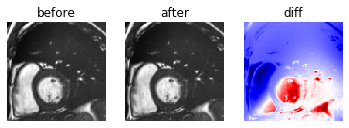

In [39]:
slice_id= 1
image_numpy= image_tensor_5d.cpu().data.numpy()
augmented_image_numpy= augmented_image.cpu().data.numpy()
plt.subplot(131)
plt.imshow(image_numpy[0,0,slice_id],cmap='gray')
plt.axis('off')
plt.title('before')
plt.subplot(132)
plt.axis('off')
plt.title('after')
plt.imshow(augmented_image_numpy[0,0,slice_id],cmap='gray')
plt.subplot(133)
plt.title('diff')
plt.axis('off')
plt.imshow(augmented_image_numpy[0,0,slice_id]-image_numpy[0,0,slice_id],cmap='seismic')